# Announcements
- Please familiarize yourself with the term projects, and sign up for your (preliminary) choice using [this form](https://forms.gle/ByLLpsthrpjCcxG89). _You may revise your choice, but I'd recommend settling on a choice well before Thanksgiving._
- Recommended reading on ODEs: [Lecture notes by Prof. Hjorth-Jensen (University of Oslo)](https://www.asc.ohio-state.edu/physics/ntg/6810/readings/hjorth-jensen_notes2013_08.pdf)
- Problem Set 4 posted on D2L, due Oct 5.
- __Outlook__: Week of 9/28 will cover adaptive step size and symplectic ODE integrators, after that we'll start with PDEs 
- Conference for Undergraduate Women in Physics: online event in 2021, [applications accepted until 10/25](https://www.aps.org/programs/women/cuwip/)

# Adaptive Runge-Kutta Methods
Adapted from materials by Phil Pinto, Jonas Tjemsland, Andreas Krogen, Håkon Ånes and wikipedia

In past lectures, we have worked with different integration schemes at _fixed step size_, and varied the step size manually to test convergence. Today we discuss the consept of _adaptive step size methods_ and _embedded Runge-Kutta pairs_ for solving ODEs with user-specified accuracy. As usual, we are going to solve first-order ODE of the form

$$
\frac{\text{d}}{\text{d}t}y(t) = g(y(t), t).
$$

 The consept of adaptive step size is easily generalized to e.g. higher order ODEs, much in the same way as (fixed Order) Runge-Kutta Methods.

### Basic idea of Adaptive Runge-Kutta Methods
An adaptive Runge-Kutta method is a method that uses two different orders of approximation (one with order $p$ and one with order $p+1$) to get an estimate of the local truncation error. Thus, it is possible to set the desired accuracy of the solution by changing the step size for each iteration. This means that an adaptive step size methods will have more steps where it is needed, and fewer steps elsewhere. However, as is evident, these methods often require more calculations.

By following this idea, we can easily develop pairs of Runge-Kutta (RK) methods (one with order $p$ and one with order $p+1$) that share several of the necessary evaluations, i.e. share intermediate steps. This enables us to estimate the local truncation error with negligible computational cost compared to a step with the higher-order method. Such pairs are called $\textbf{embedded Runge-Kutta pairs}$.

### Example embedded RK pairs

It is time to define some functions that are going to calculate two different orders of approximation for the right hand side (RHS) of the ODE, namely $g(y(t),t)$. The following functions are some examples of adaptive Runge-Kutta methods. An algorithm for deriving these methods are given [on wikipedia](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Adaptive_Runge%E2%80%93Kutta_methods).

In [11]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
def odesolver12(g, t, y, h,*P):
    """Calculate the next step of an initial value problem (IVP) of
    an ODE with a RHS described by f, with an order 1 approx.
    (Eulers Method) and an order 2 approx. (Midpoint Rule). This is 
    the simplest embedded RK pair.
    Parameters:
        g: function. RHS of ODE.
        t: float. Current time.
        y: float. Current position.
        h: float. Step length.
        *P:    tuple, additional parameters for g function

    Returns:
        q: float. Order 1 approx.
        w: float. Order 2 approx.
    """
    k1 = g(t, y,*P)
    k2 = g(t+h, y+h*k1,*P)
    w = y + h*k1
    q = y + h/2.0*(k1+k2)
    return w, q

def odesolver23(g, t, y, h):
    """Calculate the next step of an IVP of an ODE with a RHS
    described by f, with an order 2 approx. (Explicit Trapezoid 
    Method) and an order 3 approx. (third order RK).
    Parameters:
        g: function. RHS of ODE.
        t: float. Current time.
        y: float. Current position.
        h: float. Step length.
        *P:    tuple, additional parameters for g function
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    k1 = g(t, y,*P)
    k2 = g(t+h, y+h*k1,*P)
    k3 = g(t+h/2.0, y+h*(k1+k2)/4.0,*P)
    w = y + h*(k1+k2)/2.0
    q = y + h*(k1+4.0*k3+k2)/6.0
    return w, q

def odesolver45(g, t, y, h):
    """Calculate the next step of an IVP of an ODE with a RHS
    described by f, with an order 4 approx. and an order 5 approx.
    Parameters:
        g: function. RHS of ODE.
        t: float. Current time.
        y: float. Current position.
        h: float. Step length.
        *P:    tuple, additional parameters for g function
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    k1 = g(t, y,*P)
    k2 = g(t+h/4.0, y+h*k1/4.0,*P)
    k3 = g(t+3.0*h/8.0, y+3.0*h*k1/32.0+9.0*h*k2/32.0,*P)
    k4 = g(t+12.0*h/13.0, y+1932.0*h*k1/2197.0-7200.0*h*k2/2197.0+7296.0*h*k3/2197.0,*P)
    k5 = g(t+h, y+439.0*h*k1/216.0-8.0*h*k2+3680.0*h*k3/513.0-845.0*h*k4/4104.0,*P)
    k6 = g(t+h/2.0, y-8.0*h*k1/27.0+2*h*k2-3544.0*h*k3/2565+1859.0*h*k4/4104.0-11.0*h*k5/40.0,*P)
    w = y + h*(25.0*k1/216.0+1408.0*k3/2565.0+2197.0*k4/4104.0-k5/5.0)
    q = y + h*(16.0*k1/135.0+6656.0*k3/12825.0+28561.0*k4/56430.0-9.0*k5/50.0+2.0*k6/55.0)
    return w, q

### Decide adaptive stepsize

In the above function definitions $w$ represents the lowest order approximation, and $q$ the higher order approximation. When $h$ is small, a good error estimate for $w$ is

$$
e_{i+1}\approx \left|q_{i+1}-w_ {i+1}\right|.
$$

The idea is that one can perform one step of the computation and then check the error estimate $e_i$, or the relative error $e_i/\left|w_i\right|$. If the error is larger than a chosen tolerance, $TOL$, the stepsize is reduced by a predefined amount, often set to double or halve the step size. 

We always want to minimize our use of computational resources, but still be within the given tolerance. Thus, it would be a good idea to change the step size for the next step only if e.g. the error of the current step is smaller than $TOL/20$. There are however more sophisticated ways to change the step size. 

If we let the tolerance be given by the relative error, $TOL > e_i/\left|w_i\right|$, and assume that $w$ is of order $p$, the error is given by $e_i = \mathcal{O}(h^{p+1})$. By assuming that

$$
e_i\approx \xi h_i^{p+1},
$$

for a constant $\xi$, the step size that is closest to the tolerance is given by

$$
TOL\cdot \left|w_i\right| = \xi h^{p+1}.
$$

This yields

$$
\tilde h = \left(\frac{TOL\cdot |w_i|}{e_i}\right)^{1/{p+1}}h_i,
$$

where $\tilde h$ is the ideal value for the next step size. However, a safety factor is often added, such that the next step size becomes e.g. $h_{i+1}=0.8 \cdot\tilde h$. Moreover, we often use $e_i/\max(w_i, \theta)$ $(\theta>0)$ instead of the relative error to protect againt small $w_i$.

This algorithm for the step size variation is derived for $w_i$, the lowest order approximation. However, since the higher order approximation $q_i$ is available (without extra computation), this is often used to evaluate the next step.

The simplest way to visualize the adaptive step size method is with examples.

### Example 1
First we choose the RHS of the ODE to be

$$
g(y(t),t) = t - 2ty,
$$

which has the analytical solution $\frac{1}{2}(1-e^{-t^2})$. Let us define these functions and get on with solving the ODE using the simplest embedded RK method with an order 1 and an order 2 approximation. We generalize the implementation of the adaptive RK method so that we don't repeat ourselves.

In [13]:
def RHS1(t, y,*P):
    return t - 2*t*y

def analytical(t, y,*P):
    return 0.5*(1-np.exp(-t**2))

def rk_adaptive(ode, rhs, *P,y0=0.0, t0=0.0, TOL=1e-04, theta=1e-02, tmax=1.0):
    """Perform an adaptive RK method.
    Parameters:
        ode:   function. ODE solver.
        rhs:   function. RHS of ODE.
        *P:    tuple, additional parameters for rhs function
        y0:    float, optional. Initial position.
        t0:    float, optional. Initial time.
        TOL:   float, optional. Tolerance of relative error.
        theta: float, optional. "Protective" constant.
        tmax:  float, optional. End of calculation interval.
    Returns:
        y:     list. Position.
        t:     list. Time.
        i:     int. Number of iterations
    """
    
    # Allocate lists to store position and time and set
    # initial conditions.
    y = []
    t = []
    y.append(y0)
    t.append(t0)
    
    # Set initial step size and declare iteration integer
    h = 1.0
    i = 0
    
    while (t[i] < tmax):
        # Get two different approximations
        w, q = ode(rhs, t[i], y[i], h,*P)
        # Estimate error
        e = abs((w-q)/max(w, theta))
        # If e larger thant TOL, decrease step length
        if (e > TOL):
            h = 0.8*(TOL*e)**(1/5)*h
            # Get two new approximations
            w, q = ode(rhs, t[i], y[i], h,*P)
            # Estimate new error
            e = abs((w-q)/max(w, theta))
            # If e still larger than TOL, halve step length until False
            while (e > TOL):
                h = h/2.0
                # New approximations
                w, q = ode(rhs, t[i], y[i], h,*P)
                # New error estimate
                e = abs((w-q)/max(w, theta))
        # Store highest order approximation as next y-value
        y.append(q)
        # Store current time + step size as next time
        t.append(t[i] + h)
        # Increment step number
        i += 1
        # Check if e is too small, if so, double step size
        if (e < 0.1*TOL):
            h = h*2.0
    
    return y, t, i

In [14]:
# Calculate the position as a function of time using the adaptive
# Runge-Kutta odesolver12 defined above
P =()
pos, times, iterations = rk_adaptive(odesolver12, RHS1, *P, y0=0.0, t0=0.0, TOL=1e-02, theta=1e-03, tmax=1.0)

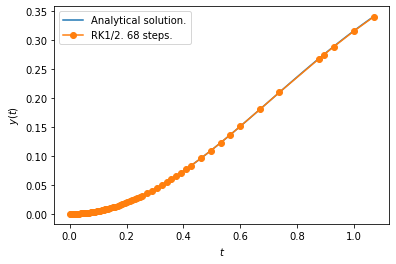

In [15]:
# Declare plot and plot results
plt.figure()

# Analytical plot
ta = np.linspace(0, times[iterations])
ya = analytical(ta, 0)
plt.plot(ta, ya , label='Analytical solution.')

# RK1/2 plot
plt.plot(times, pos, '-o' , label='RK1/2. %i steps.' % (iterations+1))
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.legend(loc="best");

We observe that the RK method uses 68 steps following the curve nicely, using an increasing step size $h$ as $t$ increases.
### Example 2
We now want to solve the IVP given by

$$
y'(t)=\cos(y(t)\cdot t^2),\quad y(1)=3,
$$

trying out all three embedded RK pair functions defined above.

In [16]:
def RHS2(t, y,*P):
    return np.cos(y*t**2)

In [17]:
start12 = time.time()
pos12, time12, iterations12 = rk_adaptive(odesolver12, RHS2, *P,y0=3.0, t0=1.0, tmax=3.0)
print("RK1/2 run time: %.5f s. Iterations: %i." % (time.time() - start12, iterations12 + 1))

start23 = time.time()
pos23, time23, iterations23 = rk_adaptive(odesolver23, RHS2, *P,y0=3.0, t0=1.0, tmax=3.0)
print("RK2/3 run time: %.5f s. Iterations: %i." % (time.time() - start23, iterations23 + 1))

start45 = time.time()
pos45, time45, iterations45 = rk_adaptive(odesolver45, RHS2, *P,y0=3.0, t0=1.0, tmax=3.0)
print("RK4/5 run time: %.5f s. Iterations: %i." % (time.time() - start45, iterations45 + 1))

RK1/2 run time: 0.01009 s. Iterations: 453.
RK2/3 run time: 0.00455 s. Iterations: 110.
RK4/5 run time: 0.00197 s. Iterations: 20.


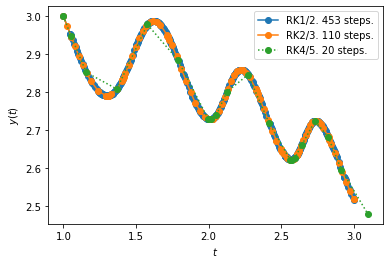

In [20]:
plt.figure()
plt.plot(time12, pos12, '-o', label='RK1/2. %i steps.' % (iterations12+1))
plt.plot(time23, pos23, '-o', label='RK2/3. %i steps.' % (iterations23+1))
plt.plot(time45, pos45, ':o', label='RK4/5. %i steps.' % (iterations45+1))
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.legend(loc="best");

We observe that the RK4/5 method approximates the function values equally as well as the RK1/2 method does in 433 fewer steps and approximately 1/5 of the time.

# Special Considerations: Symplectic Integrators
Some systems of ODEs have special properties, for example constants of motion, that should be
conserved by the system. Simple examples in mechanics are the energy, linear momentum, and angular
momentum. Sometimes it is more important to build in to the integration scheme these conservation
laws than to achieve a high accuracy per step size. Normally, the error in the solution grows as the
solution evolves, bounded by the number of steps times the error per step.  For certain schemes,
however, while they still make errors, the errors will be of such a form that the conserved quantities
will be better preserved.


Let us first consider a one-dimensional potential, which produces an
acceleration $a(x)$:
\begin{equation}
\ddot{x} = a(x).
\end{equation}
Write the position and velocity at time $t_{i+1} = t_i + \delta t$ as
a Taylor series to $\mathcal{O}(\delta t^3)$ in position and $\mathcal{O}(\delta t^2)$ in
velocity:
\begin{eqnarray}
v_{n+1} &=& v_n + a_n \delta t + \mathcal{O}(\delta t^2) \nonumber \\
x_{n+1} &=& x_n + v_n \delta t + {1\over 2} a_n (\delta t)^2 + \mathcal{O}(\delta t^3)\nonumber
\end{eqnarray}
Now do the same thing for $t_{n-1}$:
\begin{eqnarray}
v_{n-1} &=& v_n - a_n \delta t + \mathcal{O}(\delta t^2) \nonumber \\
x_{n-1} &=& x_n - v_n \delta t + {1\over 2} a_n (\delta t)^2 + \mathcal{O}(\delta t^3) \nonumber
\end{eqnarray}
If we add the two series for $x_n$, we have
\begin{equation}
\label{V1}\tag{1a}
x_{n+1} = 2 x_n - x_{n-1} + a_n(\delta t)^2 + \mathcal{O}(\delta t^3) ,
\end{equation}
while subtracting them leads to
\begin{equation}
\label{V12}\tag{1b}
v_n = {{x_{n+1}-x_{n-1}}\over{2 \delta t}} +  \mathcal{O}(\delta t^2).
\end{equation}
This expression for the second derivative is known as the _explicit
central difference_ formula. Much as the midpoint method was second order
because the slope used was _centered_ over the step, the central difference
is centered as well, using the future and past values of $x$ to give the
time derivative of $x$ at the present.

This is a commonly-used formula for solving Newton's law, known as the
__position form__ of the __Verlet algorithm__. It has one disadvantage,
however; it is not self-starting because of the $x_{n-1}$ term. A different
algorithm must be used to do the first few steps($x_1$ and $x_2$). One could use
the Euler method for this, but one would have to use a smaller time-step as the
Euler method is not as accurate and you wouldn't want the starting error this
introduced to propagate through the entire solution; this would have the same
effect as using the wrong initial conditions. Another problem is that the
velocity is determined by subtracting what may be two very nearly equal numbers,
leading to a sensitivity to round-off error.

Another way to proceed is to remove the explicit appearance of $x_{n-1}$
Combining the forward difference
\begin{equation}
v_{n+1} = v_n + a_n \delta t
\end{equation}
with the backward difference
\begin{equation}
v_{n-1} = v_n - a_n \delta t
\end{equation}
gives
\begin{equation}
v_{n+1} + v_{n-1} = 2 v_n.
\label{sumv}\tag{2}
\end{equation}

Summing the two backward differences
\begin{eqnarray}
v_{n+1} &=& v_n + a_{n+1} \delta t \nonumber \\
v_{n}   &=& v_{n-1} + a_n \delta t  \\
\end{eqnarray}
gives
\begin{equation}
v_{n+1} = v_{n-1} + (a_n + a_{n+1}) \delta t,
\end{equation}
into which we can substitute (\ref{sumv}) to obtain
\begin{equation}
v_{n+1} = v_n + {1\over 2}(a_n + a_{n+1}) \delta t.
\end{equation}
This is now self-starting (no $n\!-\!1$ subscripts) and avoids round-off
problems. If we combine it with a forward difference for the position
equation, we have
\begin{align}
x_{n+1} &= x_n + v_n\delta t + {1\over 2}a_n(\delta t)^2 + \mathcal{O}(\delta t^3) \tag{3a}\\
a_{n+1} &= a(x_{n+1}) \tag{3b}\\
v_{n+1} &= v_n + {1\over 2}\left(a_n + a_{n+1}\right)\delta t + \mathcal{O}(\delta t^2),\tag{3c}
\end{align}

the __velocity form__ of the Verlet algorithm. While the velocity computed in this way is only
first-order accurate, if the acceleration depends only upon position, then the
velocity appears only where multiplied by $\delta t$ in determining the positions and so
second-order accuracy is preserved. Of course, if determining the velocity to
high accuracy is required, then one might turn to a different scheme. On the
other hand, if the acceleration depends upon the velocity (for example, a drag
term), there are fewer constants of the motion to be conserved anyway, and one
of the higher-order schemes developed previously would serve.

<span style="color:blue"> Try to implement the velocity Verlet algorith, using the function signature below. We'll use this in Wednesday's class.</span>

In [ ]:
def vVerlet_step(g, t,y, h, *P):
    """Implements a full step h of the velocity Verlet algorithm
    Parameters:
        g: function. RHS of ODE.
        t: float. Current time.
        y: numpy array. [Current position,current velocity].
        h: float. Step length.
        *P:    tuple, additional parameters for g function
    Returns:
        y_next: numpy array. [next position, next velocity]
    """
    """
    Implements a full step h of the velocity Verlet algorithm
    """
    return 